In [ ]:
import os
import pickle
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Função para criar o modelo CNN
def criar_modelo():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Classes: Queimada, Sem Queimada, Não Determinada
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Treinar o modelo usando imagens do diretório
def treinar_modelo():
    dataset_dir = 'dataset/'

    gerador_treinamento = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    gerador = gerador_treinamento.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=2,
        class_mode='categorical'
    )

    print(f"Classes detectadas no dataset: {gerador.class_indices}")
    if len(gerador.class_indices) != 3:
        raise ValueError("O dataset precisa conter exatamente 3 classes. Verifique as pastas.")

    modelo = criar_modelo()
    modelo.fit(gerador, epochs=10)
    return modelo

# Salvar o modelo usando Pickle
def salvar_modelo_pickle(modelo, nome_arquivo):
    with open(nome_arquivo, 'wb') as arquivo:
        pickle.dump(modelo, arquivo)
    print(f"Modelo salvo em: {nome_arquivo}")

# Carregar o modelo salvo em Pickle
def carregar_modelo_pickle(nome_arquivo):
    caminho = os.path.join('/content', nome_arquivo)
    with open(caminho, 'rb') as arquivo:
        modelo = pickle.load(arquivo)
    print(f"Modelo carregado de: {caminho}")
    return modelo

# Pré-processar uma imagem individual
def processar_imagem(caminho_imagem):
    img = cv2.imread(caminho_imagem)
    if img is None:
        print(f"Erro: Imagem {caminho_imagem} não encontrada.")
        return None

    img_redimensionada = cv2.resize(img, (128, 128))
    img_normalizada = img_redimensionada / 255.0
    input_img = np.expand_dims(img_normalizada, axis=0)
    return input_img

# Fazer predições em lote de imagens
def prever_lote(caminhos_imagens, nome_modelo, nomes_classes):
    modelo = carregar_modelo_pickle(nome_modelo)
    resultados = []

    for caminho in caminhos_imagens:
        img = processar_imagem(caminho)
        if img is not None:
            previsoes = modelo.predict(img)
            probabilidades = previsoes[0]
            indice_classe = np.argmax(probabilidades)
            classe_prevista = nomes_classes[indice_classe]

            resultados.append({
                "imagem": caminho,
                "classe_prevista": classe_prevista,
                "probabilidades": probabilidades.tolist()
            })

    return resultados

# Execução principal
if __name__ == "__main__":
    modo = input("Digite 'treinar' para treinar o modelo ou 'prever' para usar o modelo: ").strip().lower()

    if modo == 'treinar':
        modelo = treinar_modelo()
        salvar_modelo_pickle(modelo, 'modelo_final.pkl')

    elif modo == 'prever':
        nomes_classes = ['Sem Queimada', 'Queimada', 'Não Determinada']
        caminhos_imagens = ['7df563a0-gp1symn9_cprght_reduced-1024x684.jpeg', 'images.jfif', 'forest.0.jpg', 'forest.1.jpg']
        nome_modelo = 'modelo_final.pkl'
        previsoes = prever_lote(caminhos_imagens, nome_modelo, nomes_classes)

        for resultado in previsoes:
            print(f"Imagem: {resultado['imagem']}")
            print(f"Classe Prevista: {resultado['classe_prevista']}")
            print(f"Probabilidades: {resultado['probabilidades']}")
            print("-" * 30)
    else:
        print("Modo inválido. Digite 'treinar' ou 'prever'.")


Enter 'train' to train the model or 'predict' to use the model: predict


Model loaded from: /content/final_model.pkl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: 7df563a0-gp1symn9_cprght_reduced-1024x684.jpeg
Predicted Class: Queimada
Probabilities: [0.36313340067863464, 0.37100937962532043, 0.2658572793006897]
------------------------------
Image: images.jfif
Predicted Class: Queimada
Probabilities: [0.3282744586467743, 0.4322226643562317, 0.23950286209583282]
------------------------------
Image: forest.0.jpg
Predicted Class: Sem Queimada
Probabilities: [0.4316580593585968, 0.2426266074180603, 0.3257153034210205]
------------------------------
Image: forest.1.jpg
Predicted Class: Não Determinada
Probabilities: [0.0064353845082223415, 0.02365909144282341, 0.9699054956436157]
------------------------------


In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`


In [ ]:
import os

dataset_dir = 'dataset/'

for folder in ['queimada', 'sem_queimada', 'nao_determinada']:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.exists(folder_path):
        print(f"Classe '{folder}' contém {len(os.listdir(folder_path))} imagens.")
    else:
        print(f"Classe '{folder}' não existe!")


Classe 'queimada' contém 13 imagens.
Classe 'sem_queimada' contém 14 imagens.
Classe 'nao_determinada' contém 2 imagens.


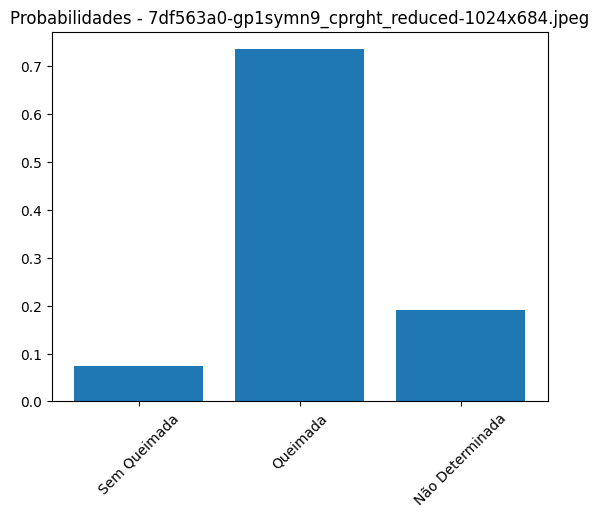

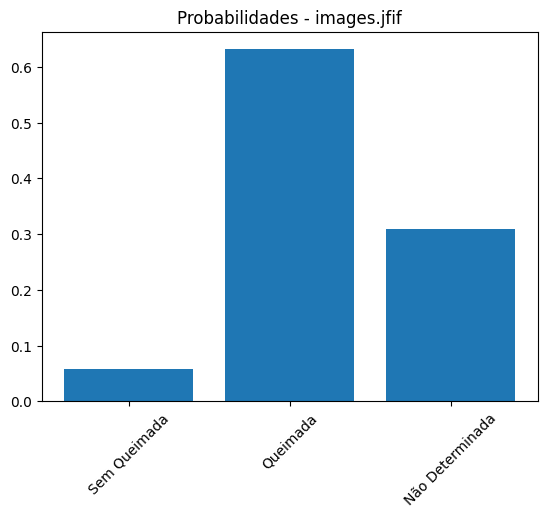

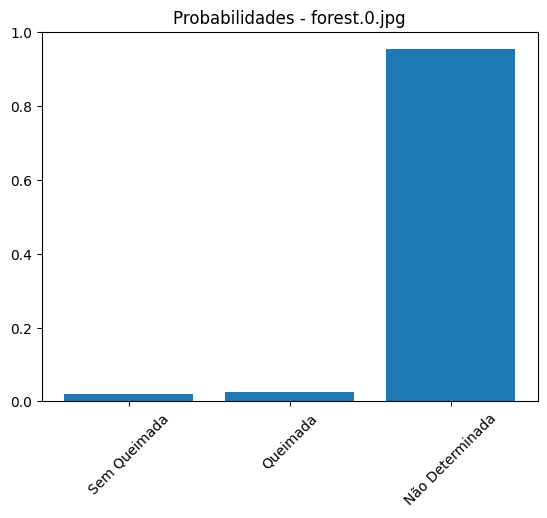

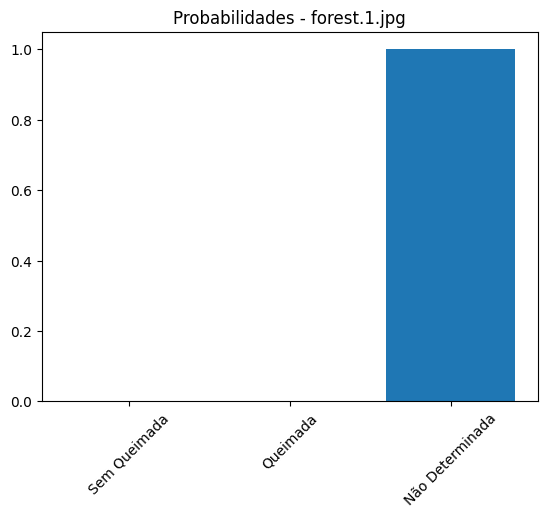

In [ ]:
import matplotlib.pyplot as plt

for result in predictions:
    plt.bar(range(len(result['probabilities'])), result['probabilities'])
    plt.xticks(range(len(result['probabilities'])), class_names, rotation=45)
    plt.title(f"Probabilidades - {result['image']}")
    plt.show()